<a href="https://colab.research.google.com/github/hmgu-itg/VolosSummerSchool/blob/master/VSS_2023/3_Workshop_Genetic_Association/3_Workshop_Genetic_Association.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Performing a quantitative trait genome-wide association study: 
from data preparation to analysis of results

# Objectives
In this workshop you will learn the basic skills needed to perform genetic association studies, from file format manipulation to filtering, single-point association and visualisation of results. We will be working with a simulated  phenotype (let's say it's a blood metabolite measurement) and the QCed dataset you produced in Workshop 2

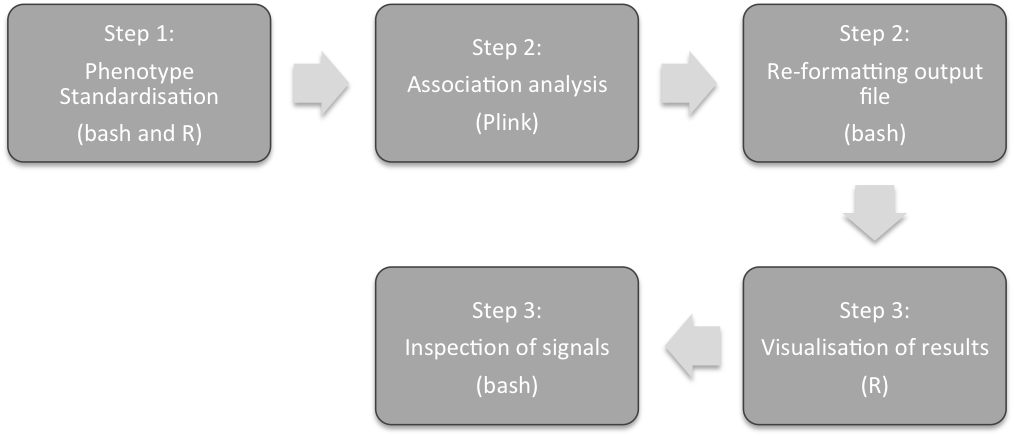


<figure>
  <img src="./WS3_workflow.png" width="60%" alt="" />
  <figcaption><i><center>Fig. 1: Workflow of the different analysis stages covered in the workshop</center></i></figcaption>
</figure>



We will be using <code>plink</code> to run the association and R to standardise our phenotype and visualise the results.
You can find a manual and command reference of <code>plink</code> [here](https://www.cog-genomics.org/plink/1.9/).

In R we will be using the package <code>data.table</code>, which provides a lot of useful commands, such as <code>fread</code> for fast reading in of large files. If you want to find out more about <code>data.table</code> and its perks, you can do so [here](https://cran.r-project.org/web/packages/data.table/vignettes/datatable-intro.html) and [here](https://cran.r-project.org/web/packages/data.table/data.table.pdf).


### Files, Software, Libraries

### Google Drive

Let us set up the connection with Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# this is the file path to your google drive (/content/drive/My Drive/) followed up by the data path

dir_path='/content/drive/My Drive/Complex_Traits/3_Workshop_Genetic_Association/' 


### Sofware and libraries

Install the rpy2 package that allows us to run R from a python notebook

In [ ]:
!pip install rpy2==3.1.0

In [ ]:
import os # python related package to list files in the defined directory
import rpy2.ipython 
%load_ext rpy2.ipython

In [ ]:
%%R 
dir_path = '/content/drive/My Drive/Complex_Traits/3_Workshop_Genetic_Association/data/'
setwd(paste0(dir_path))

### Downloading PLINK software

In [ ]:
!wget https://s3.amazonaws.com/plink1-assets/plink_linux_x86_64_20210606.zip && unzip plink_linux_x86_64_20210606.zip && rm prettify toy.* LICENSE
!rm *.zip

# Step 1: Phenotypes


In large-scale sample collections you will often find that some individuals do not have a data entry for your phenotype of interest.

This is normally not a problem, as long as it doesn't affect too many samples. Association programs like <code>plink</code> and <code>SNPTEST</code> treat certain values (usually NA or -9) as missing phenotypes and exclude the corresponding samples automatically.

Nevertheless, it is good practice to check how many samples have missing phenotypes before running an association, and also make sure that their phenotype is set to an accepted missing value.

<br>

<div class="alert alert-success"><b>Question 1:</b>  In the <code>data</code> folder you will find a file called <code>cohort1_pheno.txt</code> containing sample IDs and phenotype values. Using the command line, count the number of "NA" phenotypes.</div>

<br>




In [ ]:
# use this tab and try to solve the task by youself

In [ ]:
#@title Solution
%%bash

awk '$2=="NA"{print}' cohort1_pheno.txt | wc -l

# alternatively, you can use grep
# grep 'NA$' cohort1_pheno.txt | wc -l

## Data Cleaning and Standardisation



When working with quantitative traits, such as height, BMI or blood lipids, you will often find that the measurements in your cohort do not follow a normal distribution. 
____

This could simply be due to the way your samples were collected - e.g. height follows an approximately normal distrbution at the population level; however, if you randomly pick 100 people, you might end up with a skewed distribution, simply because by chance there is a disproportionate number of very tall people in your sample.
____

On the other hand, some traits naturally follow a non-normal distribution, such as certain blood metabolites. Since linear regression models rely on the assumption of a normally distributed response variable (the phenotype), it is important to inspect your phenotype measurements and, if necessary, standardise them before conducting a GWAS.

<div class="alert alert-success"><b>Question 2:</b>  Load the <code>cohort1_pheno.txt</code> file in R and look at the distribution of the phenotype values. How might you visualise this? Are there any outliers?</div>

In [ ]:
# use this tab and try to solve the task by youself





In [ ]:
#@title Solution
%%R

library(data.table)
d=fread("cohort1_pheno.txt")
hist(d$V2, xlab="Phenotype", main="Raw phenotype")

From the plot you can see that there are outlier phenotype measurements in the negative range, which we will exclude. 
Depending on the type of trait you are looking at, you will have different criteria for outlier definition. For phsyiological or anthropometric measurements it is a good rule of thumb to look for negative values or ones that are biologically impossible (for example, it's highly unlikely to find someone who is 900m tall!)

Next, we want to exclude the outliers and re-examine the phenotype distribution.

These steps can again be performed in R:

In [ ]:
%%R

# set outliers to NA
d[V2<0,V2:=NA]

# re-examine distribution
hist(d$V2,xlab="Phenotype", main="Raw phenotype without outliers")

<div class="alert alert-success"><b>Question 3:</b>  What distribution does the phenotype follow? Can you come up with a way to transform this distribution to a standard normal one?</div>


In [ ]:
# use this tab and try to solve the task by youself






In [ ]:
#@title Solution
%%R

# we use an inverse-normal transformation to standardise our phenotype
c=3/8
d$stdnorm=qnorm((rank(d$V2,na.last="keep")-c)/(nrow(d)-2*c+1))

# let's take a look at the transformed phenotype
hist(d$stdnorm,xlab="Phenotype", main="Transformed phenotype")

<div class="alert alert-success"><b>Bonus Question:</b> What does the <code>na.last</code> parameter in the <code>rank</code> function above do? Why is it important to set it to <code>"keep"</code>?</div>

> Inverse-normal transformations are one of the main ways to standardise non-normally distrubted phenotypes. More details on the formula we used above are summarised in [this](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2921808/) paper. 

> Setting <code>c</code> to 3/8 may seem arbitrary, and it kind of is. As discussed in the above paper under "Distinguishing among INTs", the choice of value for <code>c</code> makes very little to no difference, but 3/8 is the most common.

Now that we have transformed our phenotype, we just need to save it to a <code>Plink</code> [compatible format](https://www.cog-genomics.org/plink/1.9/input#pheno). The <code>Plink</code> pheno file is similar to a .fam file, with the first two columns being individual and family IDs; the third column should contain the phenotype values.


In [ ]:
%%R
d

In [ ]:
%%R
# Are NAs compatible with plink?
head(d[,.(V1,V1,stdnorm)])
summary(d)
x<-which(is.na(d$stdnorm))
x
d[x,3]<--9
summary(d)

In [ ]:
%%R 
# save file
fwrite(d[,.(V1,V1,stdnorm)],
            "cohort1_pheno_final.txt",
            col.names=F,row.names=F,
            quote=F,
            sep="\t")

# Step 2: Analysis

<br>
<div class="alert alert-warning"><b>Location:</b> Input files for this step are located in the <code>data</code> folder.</div>
__

<div class="alert alert-success"><b>Question 4:</b> We want to perform genetic association in our cohort with our transformed phenotype stored in the <code>cohort1_pheno_final.txt</code> file. Run the association using <code>PLINK</code></div>


In [ ]:
# try yourself
!./plink # add the necessary arguments and name the output as cohort1_assoc



To run the association analysis we will use the QCed dataset from workshop 2 and the phenotype file we created above.

In [ ]:
#@title Solution
!./plink --bfile cohort1 --assoc --pheno cohort1_pheno_final.txt --out cohort1_assoc


This command will produce an output file in the [`qassoc`](https://www.cog-genomics.org/plink2/formats#qassoc) format ("q" stands for quantitative, as our trait is not binary).


> PLINK association reports are very readable for the human eye, but not so for other programs (mainly because Plink adds multiple spaces to display rows in an orderly fashion, rather than tabs). Let's take some time to make our file more computer-friendly.

> We want to remove multiple whitespace characters and convert the file to a tab-delimited format:


In [ ]:
%%bash
sed -i 's/^ \+//g' cohort1_assoc.qassoc
sed -i 's/ \+/\t/g' cohort1_assoc.qassoc

## Additional information

It is useful to add other columsn to the .qassoc file, such as alleles and allele frequencies. This is not only good for future reference, but also important for subsequent meta-analysis. To get allele frequencies, we again run Plink:

In [ ]:
!./plink --bfile cohort1 --freq --out cohort1_maf

This produces a [.frq](https://www.cog-genomics.org/plink/1.9/formats#frq) file. Similar to the .qassoc file, we want to remove redundant whitespace characters and change the delimiter to tabs.

In [ ]:
%%bash
sed -i 's/^ \+//g' cohort1_maf.frq
sed -i 's/ \+/\t/g' cohort1_maf.frq


**N.B.:** For Plink, "A1" is usually the minor allele and also set as the risk allele.

Next, we add this information to the association summary statistics together with the alleles, which we get from the .fam file.

In [ ]:
%%bash

join -1 2 -2 1 <(sort -k2,2 cohort1_assoc.qassoc) <(cut -f2,5,6 cohort1.bim | sort -k1,1) | sed -e 's/ \+/\t/g' > temp

cat <(echo -e "SNP CHR BP NMISS BETA SE R2 T P A1 A2 AF_A1") <(join -1 1 -2 1 <(sort -k1,1 temp) <(cut -f2,5 cohort1_maf.frq | sort -k1,1)) | sed -e 's/ \+/\t/g' > temp2

mv temp2 cohort1_assoc.qassoc
rm temp

In [ ]:
%%bash
head cohort1_assoc.qassoc

# Step 3: Visualisation of results

<br>
<div class="alert alert-warning"><b>Location:</b> Input files for this step are located in the <code>data</code> folder.</div>


Now that you have run the association, you will want to see whether there are any significant associations in your data.
There are two main plots generated after an association run:

* **The Quantile-Quantile (QQ)** plot is essentially a diagnostic plot. It compares the distribution of p-values against a uniform (expected) distribution. Any deviation from the expected is indicative of an issue (sample relatedness, population stratification, non-normality of phenotype values, etc...). If the associaiton p-values are systematically lower (i.e. more significant) than expected, we refer to this as "inflation".
* **The Manhattan Plot** displays the $-log_{10}$ of the SNP p-values across the genome and allows to easily spot signals (peaks).


<br>

<div class="alert alert-success"><b>Question 4:</b>  In R, use the <code>fread</code> function from the <code>data.table</code> package to read the file. Plot a QQ-plot for the association p-values using <code>qqunif</code> from the <code>gap</code> package or <code>qq</code> from the <code>qqman</code> package.</div>


In [ ]:
# use this tab and try yourself!



## Manhattan Plot Solution

In [ ]:
%%R
install.packages("qqman")

In [ ]:
%%R
library(data.table)
library(qqman)

d=fread("cohort1_assoc.qassoc")
manhattan(d,main="Manhattan plot")

In [ ]:
%%R
d[1:3,]


## qqplot Solution

In [ ]:
%%R
qq(d$P, main="QQ plot")

## The <code>qqman</code> package provides quick and useful functions to plot GWAS results. However, the code can be a bit clunky if you want to customise your Manhattan plots. 

<br>

<div class="alert alert-success"><b>Bonus Question:</b> Try to create a Manhattan plot using only base graphics.</div>

In [ ]:
%%R 
# Try it!!



In [ ]:
# @title Base Graphics Solution
%%R -w 1000 ## ignore this line

d=fread("cohort1_assoc.qassoc")

## Define colors for each chromosome 
## (a list is available at www.stat.columbia.edu/~tzheng/files/Rcolor.pdf)
colors=c(rep(c("cornflowerblue", "goldenrod"),11),"cornflowerblue")

## We must create a column with continuous basepair positions from chr1 to chr23,
## otherwise we won't be able to plot one continuous x-axis

d[CHR==1,BP2:=rank(BP)]

pos=function(x) { rank(d[CHR==x]$BP)+max(d[CHR==(x-1)]$BP2) }
for(i in 2:23) {
    d[CHR==i, BP2:=pos(i)]
}

## Generate the plot
plot(x=d$BP2, 
     y=-log(d$P, base=10), 
     pch=20, 
     col=colors[d$CHR], 
     ylab="-log(P)", 
     xlab="Chromosome", 
     xaxt="n")

## Add chromosome legends
ticks=unlist(lapply(1:23, function(x) median(d[CHR==x]$BP2)) )
mtext(seq(1,23), side=1, at=ticks)


## We draw lines at genome-wide and suggestive significance levels
abline(h=-log(5e-8, base=10), col="firebrick") # only shows if there are values that exceed that line on the y-axis
abline(h=-log(5e-6, base=10), col="firebrick", lty=2)

## What are the peaks?

From our Manhattan plot we can see that there is one locus reaching genome-wide signifcance ($p<5*10e^{-8}$) on chromosome 7.

The next step is to investigate what this locus is. We'll go over different online tools to annotate and follow-up GWAS signals in workshop 4. 

For now, let's take a closer look at our results:

This command sorts the results by p-value and displays the first few lines of the sorted file.

<div class="alert alert-success"><b>Question 5:</b> What is the rsID of the top SNP? What is its direction of effect, its MAF, chromosome position and its alleles?</div>

In [ ]:
# use this tab to investigate question 5





In [ ]:
#@title Solution
%%bash
sort -g -k9,9 cohort1_assoc.qassoc | head

## Regional Plot

It's a good idea to generate a regional plot of the signal you get (especially if you're going to publish your results).

One way to do this is to use [LocusZoom](http://locuszoom.org/), which is a web interface for creating regional, LD-annotated association plots.

However, as for the Manhattan plots, it can be useful to know how to generate a regional plot from scratch. You can annotate this plot with information like protein coding genes, which you can download from databases like [Ensembl](http://www.ensembl.org/index.html).

Since you don't want to download gene information for the entire genome, we're going to restrict it to the region of the plot. A good starting point is ±1Mb around your top SNP (although you can of course zoom in or out).

<br>
<div class="alert alert-success"><b>Question 6:</b> From Question 5 you will know that our SNP's position is 93197732 in build GRCh37. Calculate the start and end coordinates of our regional window in using <code>bash</code>.</div>


In [ ]:
%%bash
# start position

# end position


In [ ]:
#@title Solution
%%bash

# start position
echo The start position is $((93197732 - 1000000)).

# end position
echo The end position is $((93197732 + 1000000))

## Ensembl Rest API

Now let's download coordinate information for protein coding genes from Ensembl. You can do this via the [Ensmebl Rest API](https://rest.ensembl.org/).

**N.B.** Our data are in build GRCh37, but the default Ensembl Rest API uses GRCh38. We can use an archive version of the Rest API to access GRCh37 coordinates. 

The below command downloads data in a [JSON]("https://en.wikipedia.org/wiki/JSON") file from the given link, then parses the file to select only protein-coding transcripts, and outputs the gene name, chromosome, start and stop position. 


In [ ]:
%%bash

apt-get install jq

In [ ]:

!wget --no-check-certificate "http://grch37.rest.ensembl.org/overlap/region/human/7:92197732-94197732?feature=gene;content-type=application/json" -O-| jq -r '.[] | select(.biotype == "protein_coding") | "\(.external_name) \(.seq_region_name) \(.start) \(.["end"])"' > ensembl_genes.txt

Using this information, we can now create a gene-annotated regional plot in R.

In [ ]:
%%R 

# Load the data and subset it to our region of itnerest
d=fread("cohort1_assoc.qassoc")
d=d[CHR==7 & BP<(d[SNP=="rs9641123",]$BP+1000000) & BP>(d[SNP=="rs9641123",]$BP-1000000)]


In [ ]:
%%R
# read in the gene positions and create y-coordinates for them to be plotted under the association signals
# (this will make sense once you look at the plot...)
g=fread("ensembl_genes.txt")
gpos=runif(nrow(g), min=-0.99, max=-0.25)


In [ ]:
%%R
# Create the plot
plot(x=d$BP, 
     y=-log(d$P, base=10), 
     ylim=c(-1,10), 
     pch=20, 
     col="indianred", 
     axes=F, 
     xlab="", 
     ylab="")

# Add axes and labels
axis(2, 
     at=seq(0, 10, by=2), 
     labels=seq(0, 10, by=2))


mtext("P-value (-log)", 
      side=2,
      at=5, 
      line=3)


axis(side=1, 
     at=seq(92.1, 94.1, by=0.2)*1000000, 
     labels=paste0(seq(92.1, 94.1, by=0.2), "M"),
     cex.axis=0.8)


mtext("Position (chr7[GRCh37])", 
      side=1, 
      line=3)


# Highlight the top SNP
points(x=d[SNP=="rs9641123",]$BP, 
       y=-log(d[SNP=="rs9641123"]$P, base=10), 
       col="goldenrod", 
       pch=23, 
       bg="goldenrod", 
       lwd=2)


text(x=93197732, 
     y=-log(4.596e-09, base=10), 
     labels=bquote("rs9641123, p=4.6x10"^-09), 
     pos=3, 
     cex=0.9)



# Plot genes as segments below the association signals
segments(y0=gpos, 
         x0=g$V3, 
         x1=g$V4, 
         lwd=4, 
         col="lightgreen")

text(x=(g$V3+g$V4)/2,
     y=gpos+0.1,
     labels=g$V1, 
     cex=0.6)

